Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


LOCAL RANK  0
PID of this process = 21113
device: cuda
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1
model_name: brain_diffuser_30000_trials
--data_path=../dataset --model_name=brain_diffuser_30000_trials --subj=1 --num_sessions 40
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
brain_diffuser_30000_trials
ViT-L/14 cuda
torch.Size([1000, 541875])
torch.Size([1000, 541875])


100%|██████████| 1000/1000 [00:03<00:00, 253.34it/s]


0.3279997239005984
converted, now calculating ssim...


100%|██████████| 1000/1000 [00:11<00:00, 90.34it/s]


0.3855293192601691

---early, AlexNet(2)---
2-way Percent Correct: 0.9723

---mid, AlexNet(5)---
2-way Percent Correct: 0.9796
2-way Percent Correct: 0.9260
2-way Percent Correct: 0.9229
Distance: 0.715047369966167


Using cache found in /home/naxos2-raid25/kneel027/.cache/torch/hub/facebookresearch_swav_main


Distance: 0.4080789429545403
num_voxels for subj01: 15724
40
../dataset/wds/subj01/new_test/0.tar
Loaded test dl for subj1!

0 3000 3000 1000
{'nsd_general': 0.3732044994831085, 'V1': 0.374103844165802, 'V2': 0.3510933220386505, 'V3': 0.34385567903518677, 'V4': 0.3227534592151642, 'higher_vis': 0.36293497681617737}
brain_diffuser_30000_trials
0.328000
0.385529
0.972324
0.979611
0.925952
0.922882
0.715047
0.408079
     NaN
     NaN
0.373204
0.374104
0.351093
0.343856
0.322753
0.362935


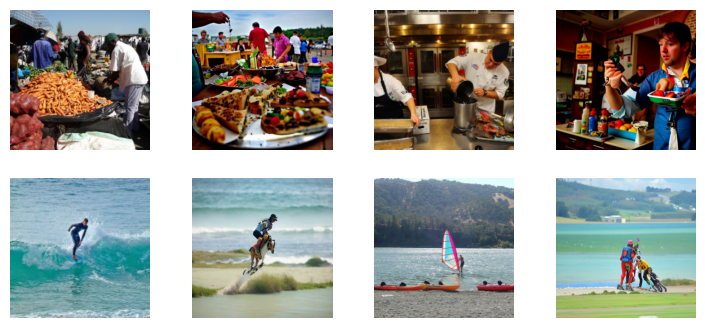

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from models import GNet8_Encoder, Clipper
from torchmetrics import PearsonCorrCoef
# import evaluate
import os
# from sentence_transformers import SentenceTransformer, util
from transformers import AutoProcessor, CLIPModel, AutoTokenizer

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False, mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']

print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)
print = accelerator.print # only print if local_rank=0
# if running this interactively, can specify jupyter_args here for argparser to use
# if utils.is_interactive():
# model_name = "git_30ep_4block_hid4096_bs48"
# model_name = "brain_diffuser_40"
# for model_name in ["brain_diffuser_125_trials"]:
# model_name = "takagi_decoded_text_01"
for model_name in ["brain_diffuser_30000_trials"]:
    subj =1
    print("model_name:", model_name)

    jupyter_args = f"--data_path=../dataset --model_name={model_name} --subj={subj} --num_sessions 40"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()

    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 
    parser = argparse.ArgumentParser(description="Model Training Configuration")
    parser.add_argument(
        "--model_name", type=str, default="testing",
        help="name of model, used for ckpt saving and wandb logging (if enabled)",
    )
    parser.add_argument(
        "--data_path", type=str, default="/fsx/proj-fmri/shared/natural-scenes-dataset",
        help="Path to where NSD data is stored / where to download it to",
    )
    parser.add_argument(
        "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
        help="Evaluate on which subject?",
    )
    parser.add_argument(
        "--num_sessions", type=int, default=0,
        help="Number of training sessions to include (zero = all sessions)",
    )
    parser.add_argument(
        "--seed",type=int,default=42,
    )
    if utils.is_interactive():
        args = parser.parse_args(jupyter_args)
    else:
        args = parser.parse_args()

    # create global variables without the args prefix
    for attribute_name in vars(args).keys():
        globals()[attribute_name] = getattr(args, attribute_name)
        
    # seed all random functions
    utils.seed_everything(seed)
    # Evals
    all_images = torch.load(f"evals/all_images.pt")
    # all_images = torch.load(f"evals/{model_name}/subj0{subj}_{model_name}_all_images.pt")
    all_recons = torch.load(f"evals/{model_name}/subj0{subj}_{model_name}_all_recons.pt")
    # all_clipvoxels = np.load(f"evals/{model_name}/subj0{subj}_pred_clip_vision.npy")
    # all_clipvoxels = torch.from_numpy(all_clipvoxels).to(device)
    # all_clipvoxels = torch.load(f"evals/{model_name}/subj0{subj}_{model_name}_all_clipvoxels.pt").float().to(device)
    # all_blurryrecons = torch.load(f"evals/{model_name}/subj0{subj}_{model_name}_all_blurryrecons.pt")
    # all_predcaptions = torch.load(f"evals/{model_name}/subj0{subj}_{model_name}_all_predcaptions.pt")
    # all_enhancedrecons = torch.load(f"evals/{model_name}/subj0{subj}_{model_name}_all_enhancedrecons.pt")
    print(model_name)
    imsize = 256
    if all_images.shape[-1] != imsize:
        all_images = transforms.Resize((imsize,imsize))(all_images).float()
    if all_recons.shape[-1] != imsize:
        all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
    fig, axes = plt.subplots(2, 4, figsize=(9, 4))
    jj=-1; kk=0;
    for j in [0,1,2,3]:
        jj+=1
        axes[kk][jj].imshow(utils.torch_to_Image(all_images[j]))
        axes[kk][jj].axis('off')
        jj+=1
        axes[kk][jj].imshow(utils.torch_to_Image(all_recons[j]))
        axes[kk][jj].axis('off')
        if jj==3: kk+=1; jj=-1
    # Retrieval eval
    # Load embedding model
    # clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    #     arch="ViT-bigG-14",
    #     version="laion2b_s39b_b160k",
    #     output_tokens=True,
    #     only_tokens=True,
    # )
    # clip_img_embedder.to(device)

    # clip_seq_dim = 256
    # clip_emb_dim = 1664

    clip_extractor = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)
    clip_seq_dim = 256
    clip_emb_dim = 768
    from scipy import stats
    percent_correct_fwds, percent_correct_bwds = [], []
    percent_correct_fwd, percent_correct_bwd = None, None

    # with torch.cuda.amp.autocast(dtype=torch.float16):
    #     for test_i, loop in enumerate(tqdm(range(30))):
    #         random_samps = np.random.choice(np.arange(len(all_images)), size=300, replace=False)
    #         # emb = clip_img_embedder(all_images[random_samps].to(device)).float() # CLIP-Image
    #         emb = clip_extractor.embed_image(all_images[random_samps].to(device)).float() # CLIP-Image
    #         emb_ = all_clipvoxels[random_samps] # CLIP-Brain

    #         # flatten if necessary
    #         emb = emb.reshape(len(emb),-1)
    #         emb_ = emb_.reshape(len(emb_),-1)

    #         # l2norm 
    #         emb = nn.functional.normalize(emb,dim=-1)
    #         emb_ = nn.functional.normalize(emb_,dim=-1)

    #         labels = torch.arange(len(emb)).to(device)
    #         bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
    #         fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip

    #         assert len(bwd_sim) == 300

    #         percent_correct_fwds = np.append(percent_correct_fwds, utils.topk(fwd_sim, labels,k=1).item())
    #         percent_correct_bwds = np.append(percent_correct_bwds, utils.topk(bwd_sim, labels,k=1).item())

    #         if test_i==0:
    #             print("Loop 0:",percent_correct_fwds, percent_correct_bwds)
                
    # percent_correct_fwd = np.mean(percent_correct_fwds)
    # fwd_sd = np.std(percent_correct_fwds) / np.sqrt(len(percent_correct_fwds))
    # fwd_ci = stats.norm.interval(0.95, loc=percent_correct_fwd, scale=fwd_sd)

    # percent_correct_bwd = np.mean(percent_correct_bwds)
    # bwd_sd = np.std(percent_correct_bwds) / np.sqrt(len(percent_correct_bwds))
    # bwd_ci = stats.norm.interval(0.95, loc=percent_correct_bwd, scale=bwd_sd)

    # print(f"fwd percent_correct: {percent_correct_fwd:.4f} 95% CI: [{fwd_ci[0]:.4f},{fwd_ci[1]:.4f}]")
    # print(f"bwd percent_correct: {percent_correct_bwd:.4f} 95% CI: [{bwd_ci[0]:.4f},{bwd_ci[1]:.4f}]")

    # fwd_sim = np.array(fwd_sim.cpu())
    # bwd_sim = np.array(bwd_sim.cpu())
    # print("Given Brain embedding, find correct Image embedding")
    # fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
    # for trial in range(4):
    #     ax[trial, 0].imshow(utils.torch_to_Image(all_images[random_samps][trial]))
    #     ax[trial, 0].set_title("original\nimage")
    #     ax[trial, 0].axis("off")
    #     for attempt in range(5):
    #         which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
    #         ax[trial, attempt+1].imshow(utils.torch_to_Image(all_images[random_samps][which]))
    #         ax[trial, attempt+1].set_title(f"Top {attempt+1}")
    #         ax[trial, attempt+1].axis("off")
    # fig.tight_layout()
    # plt.show()
    ## 2-way identification
    from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

    @torch.no_grad()
    def two_way_identification(all_recons, all_images, model, preprocess, feature_layer=None, return_avg=True):
        preds = model(torch.stack([preprocess(recon) for recon in all_recons], dim=0).to(device))
        reals = model(torch.stack([preprocess(indiv) for indiv in all_images], dim=0).to(device))
        if feature_layer is None:
            preds = preds.float().flatten(1).cpu().numpy()
            reals = reals.float().flatten(1).cpu().numpy()
        else:
            preds = preds[feature_layer].float().flatten(1).cpu().numpy()
            reals = reals[feature_layer].float().flatten(1).cpu().numpy()

        r = np.corrcoef(reals, preds)
        r = r[:len(all_images), len(all_images):]
        congruents = np.diag(r)

        success = r < congruents
        success_cnt = np.sum(success, 0)

        if return_avg:
            perf = np.mean(success_cnt) / (len(all_images)-1)
            return perf
        else:
            return success_cnt, len(all_images)-1
    ## PixCorr
    preprocess = transforms.Compose([
        transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
    ])

    # Flatten images while keeping the batch dimension
    all_images_flattened = preprocess(all_images).reshape(len(all_images), -1).cpu()
    all_recons_flattened = preprocess(all_recons).view(len(all_recons), -1).cpu()

    print(all_images_flattened.shape)
    print(all_recons_flattened.shape)

    corrsum = 0
    for i in tqdm(range(len(all_images))):
        corrsum += np.corrcoef(all_images_flattened[i], all_recons_flattened[i])[0][1]
    corrmean = corrsum / len(all_images)

    pixcorr = corrmean
    print(pixcorr)
    ## SSIM
    # see https://github.com/zijin-gu/meshconv-decoding/issues/3
    from skimage.color import rgb2gray
    from skimage.metrics import structural_similarity as ssim

    preprocess = transforms.Compose([
        transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR), 
    ])

    # convert image to grayscale with rgb2grey
    img_gray = rgb2gray(preprocess(all_images).permute((0,2,3,1)).cpu())
    recon_gray = rgb2gray(preprocess(all_recons).permute((0,2,3,1)).cpu())
    print("converted, now calculating ssim...")

    ssim_score=[]
    for im,rec in tqdm(zip(img_gray,recon_gray),total=len(all_images)):
        ssim_score.append(ssim(rec, im, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0))

    ssim = np.mean(ssim_score)
    print(ssim)
    ## AlexNet
    from torchvision.models import alexnet, AlexNet_Weights
    alex_weights = AlexNet_Weights.IMAGENET1K_V1

    alex_model = create_feature_extractor(alexnet(weights=alex_weights), return_nodes=['features.4','features.11']).to(device)
    alex_model.eval().requires_grad_(False)

    # see alex_weights.transforms()
    preprocess = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    layer = 'early, AlexNet(2)'
    print(f"\n---{layer}---")
    all_per_correct = two_way_identification(all_recons.to(device).float(), all_images, 
                                                            alex_model, preprocess, 'features.4')
    alexnet2 = np.mean(all_per_correct)
    print(f"2-way Percent Correct: {alexnet2:.4f}")

    layer = 'mid, AlexNet(5)'
    print(f"\n---{layer}---")
    all_per_correct = two_way_identification(all_recons.to(device).float(), all_images, 
                                                            alex_model, preprocess, 'features.11')
    alexnet5 = np.mean(all_per_correct)
    print(f"2-way Percent Correct: {alexnet5:.4f}")
    ## InceptionV3
    from torchvision.models import inception_v3, Inception_V3_Weights
    weights = Inception_V3_Weights.DEFAULT
    inception_model = create_feature_extractor(inception_v3(weights=weights), 
                                            return_nodes=['avgpool']).to(device)
    inception_model.eval().requires_grad_(False)

    # see weights.transforms()
    preprocess = transforms.Compose([
        transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    all_per_correct = two_way_identification(all_recons, all_images,
                                            inception_model, preprocess, 'avgpool')
            
    inception = np.mean(all_per_correct)
    print(f"2-way Percent Correct: {inception:.4f}")
    ## CLIP
    import clip
    clip_model, preprocess = clip.load("ViT-L/14", device=device)

    preprocess = transforms.Compose([
        transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                            std=[0.26862954, 0.26130258, 0.27577711]),
    ])

    all_per_correct = two_way_identification(all_recons, all_images,
                                            clip_model.encode_image, preprocess, None) # final layer
    clip_ = np.mean(all_per_correct)
    print(f"2-way Percent Correct: {clip_:.4f}")
    ## Efficient Net
    import scipy as sp
    from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
    weights = EfficientNet_B1_Weights.DEFAULT
    eff_model = create_feature_extractor(efficientnet_b1(weights=weights), 
                                        return_nodes=['avgpool'])
    eff_model.eval().requires_grad_(False)

    # see weights.transforms()
    preprocess = transforms.Compose([
        transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    gt = eff_model(preprocess(all_images))['avgpool']
    gt = gt.reshape(len(gt),-1).cpu().numpy()
    fake = eff_model(preprocess(all_recons))['avgpool']
    fake = fake.reshape(len(fake),-1).cpu().numpy()

    effnet = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
    print("Distance:",effnet)
    ## SwAV
    swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
    swav_model = create_feature_extractor(swav_model, 
                                        return_nodes=['avgpool'])
    swav_model.eval().requires_grad_(False)

    preprocess = transforms.Compose([
        transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    gt = swav_model(preprocess(all_images))['avgpool']
    gt = gt.reshape(len(gt),-1).cpu().numpy()
    fake = swav_model(preprocess(all_recons))['avgpool']
    fake = fake.reshape(len(fake),-1).cpu().numpy()

    swav = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
    print("Distance:",swav)
    # Brain Correlation
    ### Load brain data, brain masks, image lists
    # Load brain data as ground truth
    def my_split_by_node(urls): return urls

    voxels = {}
    # Load hdf5 data for betas
    f = h5py.File(f'{data_path}/betas_all_subj0{subj}_fp32_renorm.hdf5', 'r')
    betas = f['betas'][:]
    betas = torch.Tensor(betas).to("cpu")
    num_voxels = betas[0].shape[-1]
    voxels[f'subj0{subj}'] = betas
    print(f"num_voxels for subj0{subj}: {num_voxels}")
    print(num_sessions)
    if num_sessions==37: # using old test set from before full dataset released (used in original MindEye paper)
        if subj==3:
            num_test=2113
        elif subj==4:
            num_test=1985
        elif subj==6:
            num_test=2113
        elif subj==8:
            num_test=1985
        else:
            num_test=2770
        test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
    else: # using larger test set from after full dataset released
        if subj==3:
            num_test=2371
        elif subj==4:
            num_test=2188
        elif subj==6:
            num_test=2371
        elif subj==8:
            num_test=2188
        else:
            num_test=3000
        test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
        
    print(test_url)
    test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                        .decode("torch")\
                        .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                        .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
    test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
    print(f"Loaded test dl for subj{subj}!\n")
    # Prep test voxels and indices of test images
    test_images_idx = []
    for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
        test_voxels = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()]
        test_images_idx = np.append(test_images_idx, behav[:,0,0].cpu().numpy())
    test_images_idx = test_images_idx.astype(int)

    assert (test_i+1) * num_test == len(test_voxels) == len(test_images_idx)
    print(test_i, len(test_voxels), len(test_images_idx), len(np.unique(test_images_idx)))
    # Load brain region masks
    brain_region_masks = {}
    with h5py.File("evals/brain_region_masks.hdf5", "r") as file:
        # Iterate over each subject
        for subject in file.keys():
            subject_group = file[subject]
            # Load the masks data for each subject
            subject_masks = {"nsd_general" : subject_group["nsd_general"][:],
                            "V1" : subject_group["V1"][:], 
                            "V2" : subject_group["V2"][:], 
                            "V3" : subject_group["V3"][:], 
                            "V4" : subject_group["V4"][:],
                            "higher_vis" : subject_group["higher_vis"][:]}
            brain_region_masks[subject] = subject_masks
    subject_masks = brain_region_masks[f"subj0{subj}"]

    # Average voxels of test set across trial repetitions for brain correlation scores
    test_voxels_averaged = torch.zeros((len(np.unique(test_images_idx)),num_voxels))
    # i = 0
    uniq_imgs = np.unique(test_images_idx)
    for i, uniq_img in enumerate(uniq_imgs):
        locs = np.where(test_images_idx==uniq_img)[0]
        if len(locs)==1:
            locs = locs.repeat(3)
        elif len(locs)==2:
            locs = locs.repeat(2)[:3]
        assert len(locs)==3
        test_voxels_averaged[i] = torch.mean(test_voxels[None,locs], dim=1)

    # Prepare image list for input to GNet
    recon_list = []
    for i in range(all_recons.shape[0]):
        img = all_recons[i].detach()
        img = transforms.ToPILImage()(img)
        recon_list.append(img)

    ### Calculate Brain Correlation scores for each brain area
    # Load GNet, you may have to adjust the path to the gnet_multisubject model
    GNet = GNet8_Encoder(device=device,subject=subj, model_path="gnet_multisubject.pt")
    PeC = PearsonCorrCoef(num_outputs=len(recon_list))
    beta_primes = GNet.predict(recon_list)

    region_brain_correlations = {}
    for region, mask in subject_masks.items():
        score = PeC(test_voxels_averaged[:,mask].moveaxis(0,1), beta_primes[:,mask].moveaxis(0,1))
        region_brain_correlations[region] = float(torch.mean(score))
    print(region_brain_correlations)
        
    ## Display in table
    # Create a dictionary to store variable names and their corresponding values
    import pandas as pd
    data = {
        "Metric": ["PixCorr", "SSIM", "AlexNet(2)", "AlexNet(5)", "InceptionV3", "CLIP", "EffNet-B", "SwAV", "FwdRetrieval", "BwdRetrieval",
                "Brain Corr. nsd_general", "Brain Corr. V1", "Brain Corr. V2", "Brain Corr. V3", "Brain Corr. V4",  "Brain Corr. higher_vis"],
        "Value": [pixcorr, ssim, alexnet2, alexnet5, inception, clip_, effnet, swav, percent_correct_fwd, percent_correct_bwd, 
                region_brain_correlations["nsd_general"], region_brain_correlations["V1"], region_brain_correlations["V2"], region_brain_correlations["V3"], region_brain_correlations["V4"], region_brain_correlations["higher_vis"]]}

    df = pd.DataFrame(data)
    print(model_name)
    # print(df.to_string(index=False))
    print(df["Value"].to_string(index=False))
    # print(df["Metric"].to_string(index=False))

    # save table to txt file
    os.makedirs('tables/',exist_ok=True)
    df["Value"].to_csv(f'tables/{model_name}_subj0{subj}.csv', sep='\t', index=False)